### Load the Libraries

In [87]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfullerbe
import yfinance as yf
from date_selection import select_date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import math
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
import requests
import time
from datetime import date
from datetime import datetime
from nsepy import get_history
from dateutil.relativedelta import relativedelta
import warnings

### Function 1: Load Data from Yahoo Finance
Note: The goal is to extract the adjusted closing prices for the stock pair from Yahoo Finance API.

In [88]:
def load_data(start_date,end_date):
    global stocks
    global stock_list
    global today
    global df

    stocks_mw=list()
    stocks=list()
    stock_list=list()
    for x in range(2):
        temp=input(f"Enter ticker of stock {x+1}: ")
        stock_list.append(temp.upper()+' expiry_date')
        stocks.append(temp.upper()+'.NS')
        stocks_mw.append(temp)

    #Get Dates
    today=date.today()
    end_date=datetime.strptime(end_date,'%Y-%m-%d').date()
    new_date=end_date-relativedelta(years=1)

    #Getting Current Stock Price
    if end_date==today:
        current_price_list=list()
        for x in stocks_mw:
            try: 
                html_text=requests.get('https://www.marketwatch.com/investing/stock/'+x+'?countrycode=in').text
                soup=BeautifulSoup(html_text,'lxml')
                current_price=float(soup.find('h2',class_='intraday__price').text.replace("\n","")[1:])
                current_price_list.append(current_price)
            except: 
                temp=float(input(f'Enter current stock price for {x}: '))
                current_price_list.append(temp)

    #Loading Data
    print("Loading Data....")
    df=pd.DataFrame()
    for stock in stocks:
        prices=yf.download(stock,start_date,end_date)
        df[stock]=prices['Close']

    if end_date==today:
        df.loc[end_date]=[current_price_list[0],current_price_list[1]]

    #df=df.iloc[len(df)-200:]
    df.reset_index(inplace=True)
    df=df.drop_duplicates()
    df=df.dropna()

### Function 2: Linear Regression
This function regresses stock 1 on stock 2 and vive versa. It chooses the model with a smaller error ratio. Then, it returns the regression equation of the chosen model. It also conducts the Augmented Dickey Fuller (ADF) test on the residuals of the chosen series.

In [89]:
def model_selection():
    temp_list=[]
    global stock_list_adjusted
    global stock1
    global stock2
    global std_err
    global beta
    stock_list_adjusted=[]
    for index,val in enumerate([2,1]):
        stock1=df[[stocks[index]]]
        stock2=df[[stocks[val-1]]]
        stock1_adj=sm.add_constant(stock1) #for regression with intercept
        reg=sm.OLS(stock2,stock1_adj).fit()
        residuals=pd.DataFrame(reg.resid)
        residuals['residuals_sq']=residuals[0]*residuals[0]
        std_err=math.sqrt(sum(residuals['residuals_sq'])/(len(residuals)-2))
        error_ratio=reg.bse[0]/std_err
        temp_list.append(error_ratio)

    if temp_list[0]<temp_list[1]:
        stock_list_adjusted=stock_list
        stock1=df[stocks[0]]
        stock2=df[stocks[1]]
        stock1_adj=sm.add_constant(stock1)
        reg=sm.OLS(stock2,stock1_adj).fit()
        residuals=pd.DataFrame(reg.resid)
        beta=reg.params[1]
        print(f"\nModel: {stocks[1]} = {reg.params[0]} + {reg.params[1]} * {stocks[0]} + Et")
        
        p_val=adfuller(residuals,regression='n',autolag='BIC')[1]
        if p_val<=0.05:
            print(f"\nStationary Series\n \tP-value: {np.round(p_val,6)}\n \tTest Statistic: {np.round(adfuller(residuals,regression='n',autolag='BIC')[0],6)}")  
            print(f"\nCrtical Values:\n\t1% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['1%'],6)}")
            print(f"\t5% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['5%'],6)}")
            print(f"\t10% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['10%'],6)}")
            print(f"\nLag Length: {adfuller(residuals,regression='n',autolag='BIC')[2]}")
        else:
            print(f"\nNon-Stationary Series\n \tP-value: {np.round(p_val,6)}\n \tTest Statistic: {np.round(adfuller(residuals,regression='n',autolag='BIC')[0],6)}")  
            print(f"\nCrtical Values:\n\t1% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['1%'],6)}")
            print(f"\t5% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['5%'],6)}")
            print(f"\t10% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['10%'],6)}")
            print(f"\nLag Length: {adfuller(residuals,regression='n',autolag='BIC')[2]}")
            
        residuals['residuals_sq']=residuals[0]*residuals[0]
        std_err=math.sqrt(sum(residuals['residuals_sq'])/(len(residuals)-2))
        
        fig=plt.figure()
        residuals[0].plot(kind='line',figsize=(10,6))
        plt.title('Residual Plot')
        plt.show()
        plt.close()
    
        return reg.summary()
    
    else:
        stock_list_adjusted.append(stock_list[1])
        stock_list_adjusted.append(stock_list[0])
        stock1=df[stocks[1]]
        stock2=df[stocks[0]]
        stock1_adj=sm.add_constant(stock1)
        reg=sm.OLS(stock2,stock1_adj).fit()
        residuals=pd.DataFrame(reg.resid)
        beta=reg.params[1]
        print(f"\nModel: {stocks[0]} = {reg.params[0]} + {reg.params[1]} * {stocks[1]} + Et")   
        
        p_val=adfuller(residuals,regression='n',autolag='BIC')[1]
        if p_val<=0.05:
            print(f"\nStationary Series\n \tP-value: {np.round(p_val,6)}\n \tTest Statistic: {np.round(adfuller(residuals,regression='n',autolag='BIC')[0],6)}")  
            print(f"\nCrtical Values:\n\t1% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['1%'],6)}")
            print(f"\t5% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['5%'],6)}")
            print(f"\t10% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['10%'],6)}")
            print(f"\nLag Length: {adfuller(residuals,regression='n',autolag='BIC')[2]}")
        else:
            print(f"\nNon-Stationary Series\n \tP-value: {np.round(p_val,6)}\n \tTest Statistic: {np.round(adfuller(residuals,regression='n',autolag='BIC')[0],6)}")  
            print(f"\nCrtical Values:\n\t1% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['1%'],6)}")
            print(f"\t5% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['5%'],6)}")
            print(f"\t10% level of significance: {np.round(adfuller(residuals,regression='n',autolag='BIC')[4]['10%'],6)}")
            print(f"\nLag Length: {adfuller(residuals,regression='n',autolag='BIC')[2]}")
    
        residuals['residuals_sq']=residuals[0]*residuals[0]
        std_err=math.sqrt(sum(residuals['residuals_sq'])/(len(residuals)-2))
        
        fig=plt.figure()
        residuals[0].plot(kind='line',figsize=(10,6))
        plt.title('Residual Plot')
        plt.show()
        plt.close()
        
        return reg.summary()

### Function 3: Defines Long/Short Position on the Two Stocks

In [90]:
def positions(stock1,stock2):
    global df_new
    global button1 #for short trades (tracks short open positions)
    global button2 #for long trades (tracks long open positions)
    global underlying_priceX
    global underlying_priceY
    global underlying_priceX_current
    global underlying_priceY_current
    x_adj=sm.add_constant(stock1)
    reg=sm.OLS(stock2,x_adj).fit()
    residuals=pd.DataFrame(reg.resid)
    residuals['Trigger Dev.']=residuals[0]/std_err
    residuals['Indicator']=""
    temp_index=[]
    
    button1=0
    for index,val in enumerate(residuals['Indicator']):
        if residuals.iloc[index,1]>=2.5 and button1==0:
            residuals.iloc[index,2]='Enter Short Trade'
            button1=1
        elif button1==1 and (residuals.iloc[index,1]<=1):
            residuals.iloc[index,2]='Exit Short Trade'
            button1=0
        elif button1==1 and (residuals.iloc[index,1]>=3):
            residuals.iloc[index,2]='StopLoss'
            button1=0
            
    button2=0
    for index,val in enumerate(residuals['Indicator']):
        if residuals.iloc[index,1]<=-2.5 and button2==0:
            residuals.iloc[index,2]='Enter Long Trade'
            button2=1
        elif button2==1 and (residuals.iloc[index,1]>=-1):
            residuals.iloc[index,2]='Exit Long Trade'
            button2=0
        elif button2==1 and (residuals.iloc[index,1]<=-3):
            residuals.iloc[index,2]='StopLoss'
            button2=0
            
    underlying_priceY_current=df.loc[len(df)-1,stock_list_adjusted[1][:stock_list_adjusted[1].find(" ")]+'.NS']
    underlying_priceX_current=df.loc[len(df)-1,stock_list_adjusted[0][:stock_list_adjusted[0].find(" ")]+'.NS']
        
    df_new=pd.concat([df,residuals],axis=1)

### Function 4: Graphing the Results

In [91]:
def plot_residuals(stockx,stocky,resid1):
    x_adj=sm.add_constant(stockx)
    reg=sm.OLS(stocky,x_adj).fit()
    residuals=pd.DataFrame(reg.resid)
    residuals['Trigger Dev.']=residuals[0]/std_err

    plt.figure(figsize=(14,8))

    residuals['Trigger Dev.'].plot(kind='line')
    resid1.plot(kind='line')
    
    x = np.linspace(0,len(residuals),300)
    y1 = np.linspace(2.5,2.5,300)
    plt.plot(x,y1,'g',label='2nd Std Dev')

    y2 = np.linspace(-2.5,-2.5,300)
    plt.plot(x,y2,'g')

    y3 = np.linspace(-3,-3,300)
    plt.plot(x,y3,'r')

    y4 = np.linspace(3,3,300)
    plt.plot(x,y4,'r')

    y5 = np.linspace(1,1,300)
    plt.plot(x,y5,'b')

    y6 = np.linspace(-1,-1,300)
    plt.plot(x,y6,'b')

    plt.title("Plot to Understand Trigger Deviations")
    plt.xlabel("Observation")
    plt.ylabel("Residual / Std. Error of Residuals")
    plt.yticks(np.arange(-4,4.5,0.5))

    # va: want the text to be vertically 'bottom' aligned ha: want the text to be horizontally 'left' algned.
    plt.annotate('Enter Short Trade',xy=(3, 2.5),rotation=0,va='bottom',ha='left')
    plt.annotate('Exit Short Trade',xy=(3, 1),rotation=0,va='bottom',ha='left')
    plt.annotate('StopLoss',xy=(3, 3),rotation=0,va='bottom',ha='left')

    plt.annotate('Enter Long Trade',xy=(3, -2.5),rotation=0,va='bottom',ha='left')
    plt.annotate('Exit Long Trade',xy=(3, -1),rotation=0,va='bottom',ha='left')
    plt.annotate('StopLoss',xy=(3, -3),rotation=0,va='bottom',ha='left')

    plt.show()
    plt.close()

### Function 5: Margin (SPAN + EXPOSURE) Calculator

In [92]:
def margin_calculator(stock_list_margin):
    global stock_info_list
    stock_info_list=[]
    keys=['stock','span_margin','exposure_margin','total_margin','lot_size']
    
    contract_expiry=int(input("Press 1: Near Month Contract, Press 2: Mid Month Contract, Press 3: Far Month Contract"))
    html_text=requests.get('https://www.moneycontrol.com/stocks/fno/view-option-chain/ICI02/').text
    soup=BeautifulSoup(html_text,'lxml')
    expiry=soup.find('select',id='sel_exp_date').text.strip().replace('\n',' ').replace(',','-')
    near_month=expiry[:7].replace(' ','-').upper()+expiry[10:12]
    mid_month=expiry[13:20].replace(' ','-').upper()+expiry[23:25]
    far_month=expiry[26:33].replace(' ','-').upper()+expiry[36:38]

    browser = webdriver.Chrome('/Users/sanjaymalhotra/Desktop/Programming/Scraping/chromedriver')
    time.sleep(3)
    browser.get('https://zerodha.com/margin-calculator/SPAN/')
    time.sleep(3)
    browser.find_element_by_id('exchange').click()
    
    dropdown=browser.find_element_by_id('exchange')
    select=Select(dropdown)
    select.select_by_visible_text('NFO')
    
    for index,x in enumerate(stock_list_margin):

        if contract_expiry==1:
            stock_list_margin[index]=x.replace('expiry_date',near_month)

        elif contract_expiry==2:
            stock_list_margin[index]=x.replace('expiry_date',mid_month)

        else:
            stock_list_margin[index]=x.replace('expiry_date',far_month)

        dict2={}
        time.sleep(3)
        
        try:
            dropdown=browser.find_element_by_id('scrip')
            select=Select(dropdown)
            select.select_by_visible_text(stock_list_margin[index])

            time.sleep(3)
            browser.find_element_by_class_name('button').click()

            time.sleep(3)
            src=browser.page_source
            soup=BeautifulSoup(src, 'lxml')
            span_margin=int(soup.find('span',class_='val span').text.replace(",","").replace("Rs. ",""))
            exposure_margin=int(soup.find('span',class_='val exposure').text.replace(",","").replace("Rs. ",""))
            total_margin=int(soup.find('span',class_='val total').text.replace(",","").replace("Rs. ",""))
            lot_size=soup.find('span',class_='val').text
            values=[stock_list_margin[index],span_margin,exposure_margin,total_margin,lot_size]

            mapped=list(zip(keys,values))
            for k,v in mapped:
                dict2[k]=v

            stock_info_list.append(dict2)

            browser.find_element_by_id('reset').click()
            
        except:
            print('Error in finding lot size')
            
    stock_list[0]=stock_list[0][:(stock_list[0].find(' '))]+' expiry_date'
    stock_list[1]=stock_list[1][:(stock_list[1].find(' '))]+' expiry_date'

### Function 6: Entry Point

In [534]:
def entry_point(stock_list_ep,df_new,trade_date_str):
    global equity
    global number_of_lots
    global temp
    global give_input
    df_temp=df_new.set_index('Date')
    df_temp=df_temp.loc[:trade_date_str]
    df_temp=df_temp.reset_index()
    stockY=df_temp.loc[:,stock_list_ep[1][:stock_list_ep[1].find(" ")]+'.NS']
    stockX=df_temp.loc[:,stock_list_ep[0][:stock_list_ep[0].find(" ")]+'.NS']
    
    x_adj=sm.add_constant(stockX)
    reg=sm.OLS(stockY,x_adj).fit()
    beta_trade=reg.params[1]
    print("Beta_Trade: ",beta_trade)
    give_input=int(input("Do you have an ongoing open position?\nPress 1: Long Trade\nPress 2: Short Trade\nPress 0: No ONGOING Open Position (we'll scan if there are any open positions for the given timeframe) "))
    if button2==1 or give_input==1:
        #Long Trade
        print('\nLong Trade')
        number_of_lots=int(input(f"Enter the number of lots you wish to short of {stock_info_list[0]['stock']} with lot size {stock_info_list[0]['lot_size']}: "))
        temp=number_of_lots
        long=np.round(int(stock_info_list[0]['lot_size'])*(number_of_lots*beta_trade))
        
        if int(stock_info_list[0]['lot_size'])*beta_trade>int(stock_info_list[1]['lot_size']):
            while number_of_lots*int(stock_info_list[1]['lot_size'])<long:
                number_of_lots=number_of_lots+1
                equity=int(long-(number_of_lots-1)*int(stock_info_list[1]['lot_size']))
            print(f"Strategy:\nLong Position in- {stock_info_list[1]['stock']}, Lots- {number_of_lots-1}, Shares- {equity}")
            print(f"Short Position in- {stock_info_list[0]['stock']}, Lots- {temp}, Shares- 0")
            number_of_lots=number_of_lots-1
        else:
            while number_of_lots*int(stock_info_list[1]['lot_size'])>long and number_of_lots>=0:
                number_of_lots=number_of_lots-1
                equity=int(long-number_of_lots*int(stock_info_list[1]['lot_size']))
            print(f"Strategy:\nLong Position in- {stock_info_list[1]['stock']}, Lots- {number_of_lots}, Shares- {equity}")
            print(f"Short Position in- {stock_info_list[0]['stock']}, Lots- {temp}, Shares- 0")
        

    elif button1==1 or give_input==2:
        #Short Trade
        print('\nShort Trade')
        number_of_lots=int(input(f"Enter the number of lots you wish to short of {stock_info_list[1]['stock']} with lot size {stock_info_list[1]['lot_size']}: "))
        temp=number_of_lots
        short=np.round(int(stock_info_list[1]['lot_size'])*(number_of_lots/beta_trade))
    
        if int(stock_info_list[1]['lot_size'])/beta_trade<int(stock_info_list[0]['lot_size']):
            while number_of_lots*int(stock_info_list[0]['lot_size'])>short and number_of_lots>=0:
                number_of_lots=number_of_lots-1
                equity=int(short-number_of_lots*int(stock_info_list[0]['lot_size'])) 
            print(f"Strategy:\nShort Position in- {stock_info_list[1]['stock']}, Lots- {temp}, Shares- 0")
            print(f"Long Position in- {stock_info_list[0]['stock']}, Lots- {number_of_lots}, Shares- {equity}")        

        else:
            while number_of_lots*int(stock_info_list[0]['lot_size'])>short:
                number_of_lots=number_of_lots+1
                equity=int(short-(number_of_lots-1)*int(stock_info_list[0]['lot_size']))
            print(f"Strategy:\nShort Position in- {stock_info_list[1]['stock']}, Lots- {temp}, Shares- 0")
            print(f"Long Position in- {stock_info_list[0]['stock']}, Lots- {number_of_lots-1}, Shares- {equity}")
            number_of_lots=number_of_lots-1
        
    else:
        print("No Open Positions")

### Function 7: Loading Trading Date Data

In [94]:
def trading_date_data(start_date,trade_date_str,stock_info_list):
    global df_new1
    trade_date=datetime.strptime(trade_date_str,'%Y-%m-%d').date()
    df1=pd.DataFrame()
    prices=yf.download(stock_info_list[0]['stock'][:stock_info_list[0]['stock'].find(' ')]+'.NS',start_date,str(trade_date+relativedelta(days=1)))
    df1[stock_info_list[0]['stock'][:stock_info_list[0]['stock'].find(' ')]+'.NS']=prices['Close']
    prices=yf.download(stock_info_list[1]['stock'][:stock_info_list[1]['stock'].find(' ')]+'.NS',start_date,str(trade_date+relativedelta(days=1)))
    df1[stock_info_list[1]['stock'][:stock_info_list[1]['stock'].find(' ')]+'.NS']=prices['Close']

    if trade_date==today:
        df1.loc[trade_date]=[current_price_list[0],current_price_list[1]]

    df1.reset_index(inplace=True)
    df1=df1.drop_duplicates()
    df1=df1.dropna()

    x_adj=sm.add_constant(df1.iloc[:,1])
    reg=sm.OLS(df1.iloc[:,2],x_adj).fit()
    residuals=pd.DataFrame(reg.resid)
    residuals['residuals_sq']=residuals[0]*residuals[0]
    std_err=math.sqrt(sum(residuals['residuals_sq'])/(len(residuals)-2))
    residuals['Trigger Dev.']=residuals[0]/std_err
    df_new1=pd.concat([df1,residuals],axis=1)
    df_new1.rename(columns={0:'resid'}, inplace=True)
    df_graph=pd.DataFrame()
    df_graph['Trigger Dev.']=df_new1['Trigger Dev.'].append(df_new.loc[len(df_new1):,'Trigger Dev.'])

    plot_residuals(stock1,stock2,df_graph.iloc[:,0])
    entry_point(stock_list_adjusted,df_new,trade_date_str)

### Function 8: Profit and Loss Calculator

In [522]:
def profit_loss(expiry_date_str,trade_date_str):
    expiry_date=datetime.strptime(expiry_date_str,'%Y-%m-%d').date()
    trade_date=datetime.strptime(trade_date_str,'%Y-%m-%d').date()
    df_pt=pd.DataFrame(columns=['Variable','Stock','Entry Date','Current Date','Position','Underlying Price','Current Underlying Price','Equity Shares','Lot Size','No. of Lots','Trade Price','Current Price','P&L_Equity','P&L_Futures'])
    df_pt['Variable']=['Y','X']
    df_pt['Stock']=[stock_info_list[1]['stock'],stock_info_list[0]['stock']]
    df_pt.loc[0,'Entry Date']=trade_date
    df_pt.loc[1,'Entry Date']=trade_date
    df_pt['Lot Size']=[int(stock_info_list[1]['lot_size']),int(stock_info_list[0]['lot_size'])]
    df_pt['Current Date']=[df_new.iloc[-1,0].date(),df_new.iloc[-1,0].date()]

    if button2==1 or give_input==1:
        #Long Trade
        df_pt['Equity Shares']=[equity,0]        
        df_pt['No. of Lots']=[number_of_lots,temp]
    elif button1==1 or give_input==2:
        #Short Trade
        df_pt['Equity Shares']=[0,equity]        
        df_pt['No. of Lots']=[temp,number_of_lots]
        
    if button1==1:
        df_pt.loc[0,'Position']='Short'
        df_pt.loc[1,'Position']='Long'
    elif button2==1:
        df_pt.loc[0,'Position']='Long'
        df_pt.loc[1,'Position']='Short'
    else:
        df_pt.loc[0,'Position']='Closed'
        df_pt.loc[1,'Position']='Closed'

    fut_price_list=list()
    fut_price_list_current=list()
    
    for index,val in enumerate(stock_list_adjusted):
        stock_fut=get_history(symbol=stock_list_adjusted[index][:stock_list_adjusted[index].find(" ")],
                                    start=trade_date,
                                    end=trade_date,
                                    futures=True,
                                    expiry_date=expiry_date)
        fut_price_list.append(stock_fut.iloc[:,7].to_list()[0])
    fut_price_list.reverse()


    for index,val in enumerate(stock_list_adjusted):
        stock_fut=get_history(symbol=stock_list_adjusted[index][:stock_list_adjusted[index].find(" ")],
                                    start=df_new.iloc[-1,0].date(),
                                    end=df_new.iloc[-1,0].date(),
                                    futures=True,
                                    expiry_date=expiry_date)
        fut_price_list_current.append(stock_fut.iloc[:,7].to_list()[0])
    fut_price_list_current.reverse()


    df_copy=df_new1
    df_copy['Date']=df_copy['Date'].astype('str')
    df_copy=df_copy.set_index('Date')
    underlying_priceY=df_copy.loc[trade_date_str,stock_list_adjusted[1][:stock_list_adjusted[1].find(" ")]+'.NS']
    underlying_priceX=df_copy.loc[trade_date_str,stock_list_adjusted[0][:stock_list_adjusted[0].find(" ")]+'.NS']
    df_pt.loc[1,'Underlying Price']=underlying_priceX
    df_pt.loc[0,'Underlying Price']=underlying_priceY
    df_pt.loc[1,'Current Underlying Price']=underlying_priceX_current
    df_pt.loc[0,'Current Underlying Price']=underlying_priceY_current
    df_pt['Trade Price']=fut_price_list
    df_pt['Current Price']=fut_price_list_current
    df_pt['P&L_Equity']=(df_pt['Current Underlying Price']-df_pt['Underlying Price'])*df_pt['Equity Shares']
    
    if button2==1 or give_input==1:
        #Long Trade
        df_pt.loc[0,'P&L_Futures']=(df_pt.loc[0,'Current Price']-df_pt.loc[0,'Trade Price'])*df_pt.loc[0,'No. of Lots']*df_pt.loc[0,'Lot Size']
        df_pt.loc[1,'P&L_Futures']=(df_pt.loc[1,'Trade Price']-df_pt.loc[1,'Current Price'])*df_pt.loc[1,'No. of Lots']*df_pt.loc[1,'Lot Size']
        
    elif button1==1 or give_input==2:
        #Short Trade
        df_pt.loc[1,'P&L_Futures']=(df_pt.loc[1,'Current Price']-df_pt.loc[1,'Trade Price'])*df_pt.loc[1,'No. of Lots']*df_pt.loc[1,'Lot Size']
        df_pt.loc[0,'P&L_Futures']=(df_pt.loc[0,'Trade Price']-df_pt.loc[0,'Current Price'])*df_pt.loc[0,'No. of Lots']*df_pt.loc[0,'Lot Size']
    
    net_profit=df_pt.loc[0,'P&L_Equity']+df_pt.loc[1,'P&L_Equity']+df_pt.loc[0,'P&L_Futures']+df_pt.loc[1,'P&L_Futures']
    margin_total=(stock_info_list[0]['total_margin']*temp+stock_info_list[1]['total_margin']*number_of_lots)+(df_pt.loc[0,'Equity Shares']*df_pt.loc[0,'Underlying Price']+df_pt.loc[1,'Equity Shares']*df_pt.loc[1,'Underlying Price'])
    print("Net Profit: ",net_profit)
    print("Total Margin Required: ",margin_total)
    print("Profit/Margin: ",net_profit/margin_total*100)
    display(df_pt)

### Results

Enter ticker of stock 1: marico
Enter ticker of stock 2: tataconsum
Loading Data....
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Model: MARICO.NS = 325.1582426037652 + 0.24163516650799077 * TATACONSUM.NS + Et

Stationary Series
 	P-value: 1.6e-05
 	Test Statistic: -4.373946

Crtical Values:
	1% level of significance: -2.574741
	5% level of significance: -1.942126
	10% level of significance: -1.615799

Lag Length: 0


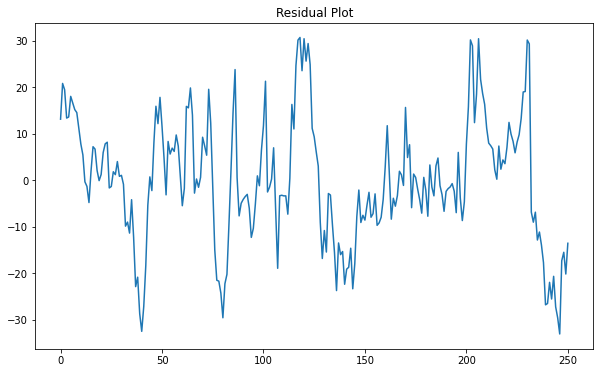

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              MARICO.NS   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     116.3
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           1.70e-22
Time:                        11:45:43   Log-Likelihood:                -1009.2
No. Observations:                 251   AIC:                             2022.
Df Residuals:                     249   BIC:                             2029.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           325.1582     17.088     19.028      0.000     291.503     358.814
TATACONSUM.NS     0.2416      0.022     10.782      0.000       0.197       0.286
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.182
Skew:                           0.012   Prob(JB):                        0.913
Kurtosis:                       2.870   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [518]:
# load_data(start_date,end_date)
load_data('2021-12-01','2022-12-04')
model_selection()

In [533]:
positions(stock1,stock2)
take_in=int(input("Do you want to run the margin calculator again? Press 1 for Yes, Press 2 for No: "))
if take_in==1:
    warnings.filterwarnings("ignore")
    margin_calculator(stock_list_adjusted)
else:
    pass
stock_info_list

Do you want to run the margin calculator again? Press 1 for Yes, Press 2 for No: 1
Press 1: Near Month Contract, Press 2: Mid Month Contract, Press 3: Far Month Contract1


[{'stock': 'TATACONSUM 25-JAN-23',
  'span_margin': 98430,
  'exposure_margin': 24326,
  'total_margin': 122756,
  'lot_size': '900'},
 {'stock': 'MARICO 25-JAN-23',
  'span_margin': 89781,
  'exposure_margin': 22135,
  'total_margin': 111916,
  'lot_size': '1200'}]

### Proceed ahead if the series is Stationary

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


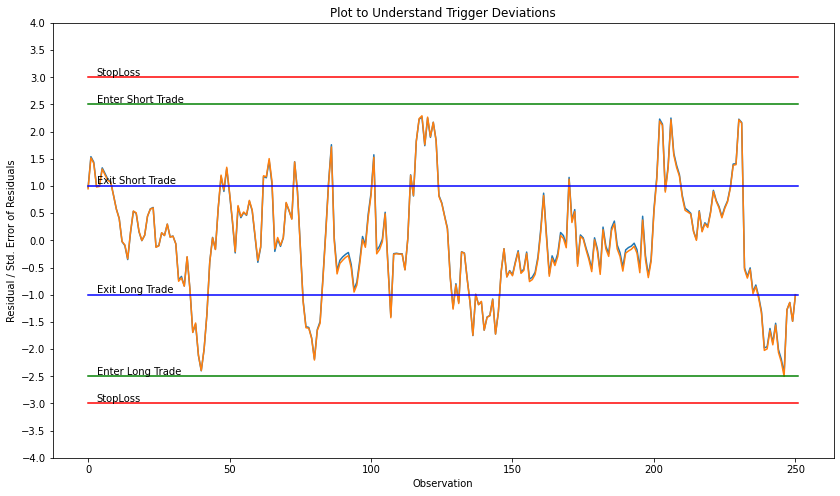

Beta_Trade:  0.250560251358388
Do you have an ongoing open position?
Press 1: Long Trade
Press 2: Short Trade
Press 0: No ONGOING Open Position (we'll scan if there are any open positions for the given timeframe) 1

Long Trade
Enter the number of lots you wish to short of TATACONSUM 25-JAN-23 with lot size 900: 6
Strategy:
Long Position in- MARICO 25-JAN-23, Lots- 1, Shares- 153
Short Position in- TATACONSUM 25-JAN-23, Lots- 6, Shares- 0


In [547]:
# load_data(start_date,trade_date,list)
trading_date_data('2021-12-01','2022-11-28',stock_info_list)

In [548]:
# profit_loss(expiry_date,trade_date)
profit_loss('2022-12-29','2022-11-28')

Net Profit:  72442.19906616167
Total Margin Required:  922878.8518676758
Profit/Margin:  7.849589241270054


,Variable,Stock,Entry Date,Current Date,Position,Underlying Price,Current Underlying Price,Equity Shares,Lot Size,No. of Lots,Trade Price,Current Price,P&L_Equity,P&L_Futures
0,Y,MARICO 25-JAN-23,2022-11-28,2022-12-02,Closed,486.450012,503.850006,153,1200,1,490.90,508.10,2662.199066,20640.0
1,X,TATACONSUM 25-JAN-23,2022-11-28,2022-12-02,Closed,804.299988,795.549988,0,900,6,811.55,802.45,-0.0,49140.0
